# BoxToAffine visual test

From unit tests alone it's hard to tell that the BoxToAffine module is correctly translating image-space bounding box coordinates to affine transform matrices that can be fed to `AffineGridGenerator`. To check this, we prepare some bounding boxes, run `BoxToAffine`, `AffineGridGenerator`, and `BatchBilinearSamplerBHWD` to crop out the bounding boxes from the image, and visually inspect the results to make sure they match.

Another important and subtle point about `BoxToAffine` is that the same set of affine transform matrices can be used to sample from an image and from a convolutional feature map for that image, since although the two may have different sizes their normalized coordinate systems are identical. To visually test this fact, we build a ConvNet using 3x3 conv and 2x2 pool in the style of VGG; however instead of using random weights for the convolutions we arrange the convolutional filters to compute the identity transform; thus the convnet is just a fancy way to downsample the input image.

To check that the same affine transform matrix can be applied to the convolutional feature map, we run the `BatchBilinearSamplerBHWD` on the downsampled image (feature map) and the same grids as above; the crops extracted from the downsampled image should have pixel-perfect correspondence with the crops from the original image.

As an additional sanity check, we can also repeat the above experiment using the `BilinearRoiPooling` module.

In [1]:
require 'torch'
require 'nn'
require 'stn'
require 'image'

-- hack the path so we can require files from the parent directory
package.path = string.format("../?.lua;%s", package.path)

require 'densecap.modules.BilinearRoiPooling'
require 'densecap.modules.BatchBilinearSamplerBHWD'
require 'densecap.modules.BoxToAffine'

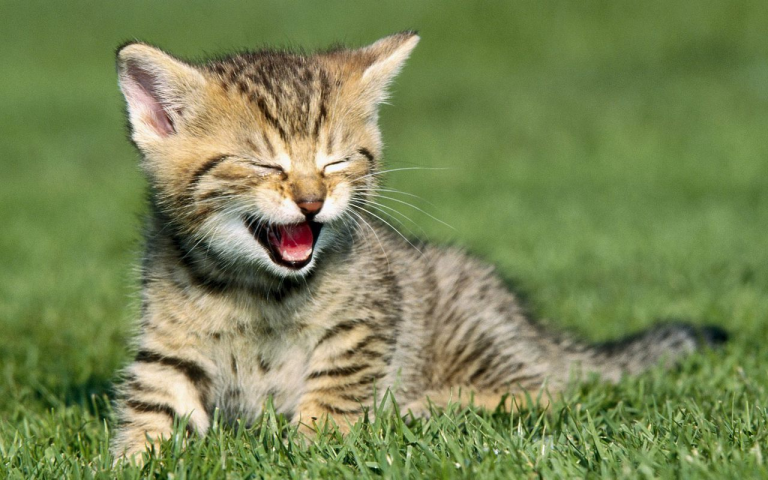

480	768	


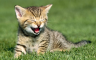

In [2]:
img = image.scale(image.load('kitten1.jpg'), 768)
itorch.image(img)

H, W = img:size(2), img:size(3)
print(H, W)
HH, WW = 128, 128

local function identity_conv(C, k)
  k = k or 3
  assert(k % 2 == 1)
  local pad = math.floor(k / 2)
  local layer = nn.SpatialConvolution(C, C, k, k, 1, 1, pad, pad)
  layer.bias:zero()
  layer.weight:zero()
  local center = math.ceil(k / 2)
  for i = 1, C do
    layer.weight[{i, i, center, center}] = 1
  end
  return layer
end

net = nn.Sequential()
net:add(identity_conv(3, 3))
net:add(nn.SpatialAveragePooling(2, 2, 2, 2))
net:add(identity_conv(3, 3))
net:add(nn.SpatialAveragePooling(2, 2, 2, 2))
net:add(identity_conv(3, 3))
net:add(nn.SpatialAveragePooling(2, 2, 2, 2))

img_small = net:forward(img)
itorch.image(img_small)

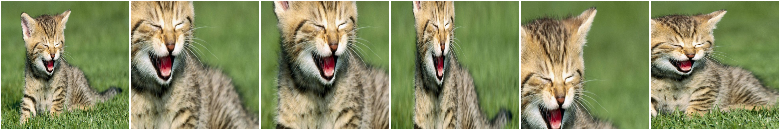

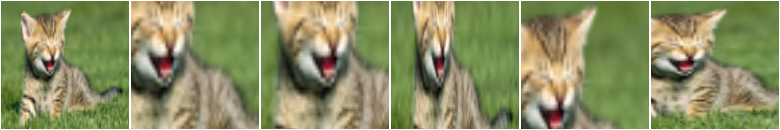

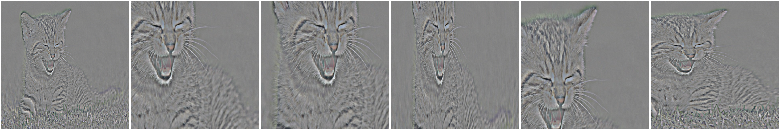

In [3]:
--[[
Prepare a bunch of boxes as a sanity check:

(1) Whole image
(2) Center crop
(3) Same as (2), but shifted to the left
(4) Same as (2), but box is twice as wide
(5) Same as (2), but box is shifted up
(6) Same as (2), but box is twice as tall

This visual test gives us confidence that the BoxToAffine module
is correctly translating image-space bounding box coordinates to
affine parameters that can be fed to the AffineGridGenerator.
--]]
boxes = torch.Tensor(6, 4)
boxes[1] = torch.Tensor{(W + 1) / 2, (H + 1) / 2, W, H}
boxes[2] = torch.Tensor{(W + 1) / 2, (H + 1) / 2, W / 2, H / 2}
boxes[3] = torch.Tensor{(W + 1) / 2 - 100, (H + 1) / 2, W / 2, H / 2}
boxes[4] = torch.Tensor{(W + 1) / 2, (H + 1) / 2, W, H / 2}
boxes[5] = torch.Tensor{(W + 1) / 2, (H + 1) / 2 - 100, W / 2, H / 2}
boxes[6] = torch.Tensor{(W + 1) / 2, (H + 1) / 2, W / 2, H}

local params = nn.BoxToAffine():setSize(H, W):forward(boxes)
local grids = nn.AffineGridGeneratorBHWD(HH, WW):forward(params)

-- print(params)

--[[
We use the same sampling grid to sample both from the input image
and from the downsampled version of the input image coming out of
our 3x3 conv, 2x2 pool convnet. They should have pixel-perfect
correspondence, except obviously the downsampled version will be blurry.

To check the pixel correspondence we also visualize their difference.
--]]

local sampler = nn.BatchBilinearSamplerBHWD()
img_hwd = img:permute(2, 3, 1):contiguous()
local samples1 = sampler:forward{img_hwd, grids}:clone()
samples1 = samples1:permute(1, 4, 2, 3)
itorch.image(samples1)

img_small_hwd = img_small:permute(2, 3, 1):contiguous()
local samples2 = sampler:forward{img_small_hwd, grids}:clone()
samples2 = samples2:permute(1, 4, 2, 3)
itorch.image(samples2)

itorch.image(samples1 - samples2)

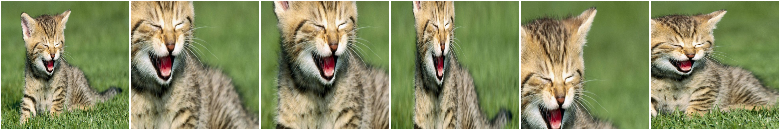

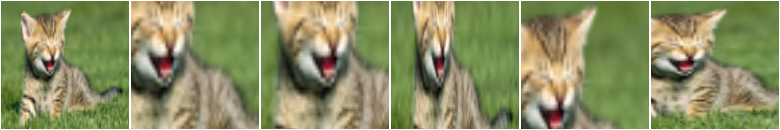

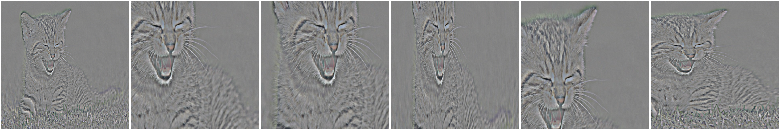

In [4]:
-- Do the same as above, but use BilinearRoiPooling instead.
-- The output should be the same.

local roi_layer = nn.BilinearRoiPooling(HH, WW)

roi_layer:setImageSize(H, W)
local samples1 = roi_layer:forward{img, boxes}:clone()
itorch.image(samples1)

roi_layer:setImageSize(H, W)
local samples2 = roi_layer:forward{img_small, boxes}:clone()
itorch.image(samples2)

itorch.image(samples1 - samples2)